In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

from nuscenes import NuScenes

In [2]:
nusc = NuScenes(
    version="v1.0-mini", 
    dataroot="../../nuscenes/",
    verbose=False,
)


In [3]:
scene = nusc.scene[0]
scene

{'token': 'cc8c0bf57f984915a77078b10eb33198',
 'log_token': '7e25a2c8ea1f41c5b0da1e69ecfa71a2',
 'nbr_samples': 39,
 'first_sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'last_sample_token': 'ed5fc18c31904f96a8f0dbb99ff069c0',
 'name': 'scene-0061',
 'description': 'Parked truck, construction, intersection, turn left, following a van'}

In [4]:
sample = nusc.get("sample", scene["first_sample_token"])
sample["data"]

{'RADAR_FRONT': '37091c75b9704e0daa829ba56dfa0906',
 'RADAR_FRONT_LEFT': '11946c1461d14016a322916157da3c7d',
 'RADAR_FRONT_RIGHT': '491209956ee3435a9ec173dad3aaf58b',
 'RADAR_BACK_LEFT': '312aa38d0e3e4f01b3124c523e6f9776',
 'RADAR_BACK_RIGHT': '07b30d5eb6104e79be58eadf94382bc1',
 'LIDAR_TOP': '9d9bf11fb0e144c8b446d54a8a00184f',
 'CAM_FRONT': 'e3d495d4ac534d54b321f50006683844',
 'CAM_FRONT_RIGHT': 'aac7867ebf4f446395d29fbd60b63b3b',
 'CAM_BACK_RIGHT': '79dbb4460a6b40f49f9c150cb118247e',
 'CAM_BACK': '03bea5763f0f4722933508d5999c5fd8',
 'CAM_BACK_LEFT': '43893a033f9c46d4a51b5e08a67a1eb7',
 'CAM_FRONT_LEFT': 'fe5422747a7d4268a4b07fc396707b23'}

In [42]:
sample_data = nusc.get("sample_data", sample["data"]["CAM_BACK_LEFT"])
sample_data

{'token': '43893a033f9c46d4a51b5e08a67a1eb7',
 'sample_token': 'ca9a282c9e77460f8360f564131a8af5',
 'ego_pose_token': '43893a033f9c46d4a51b5e08a67a1eb7',
 'calibrated_sensor_token': '3bc29be787ea4fc79144c4a46a3c91ca',
 'timestamp': 1532402927647423,
 'fileformat': 'jpg',
 'is_key_frame': True,
 'height': 900,
 'width': 1600,
 'filename': 'samples/CAM_BACK_LEFT/n015-2018-07-24-11-22-45+0800__CAM_BACK_LEFT__1532402927647423.jpg',
 'prev': '',
 'next': '63d992b6e037456c8062211c4d78bd22',
 'sensor_modality': 'camera',
 'channel': 'CAM_BACK_LEFT'}

In [43]:
calib_data = nusc.get("calibrated_sensor",sample_data["calibrated_sensor_token"])
calib_data

{'token': '3bc29be787ea4fc79144c4a46a3c91ca',
 'sensor_token': 'a89643a5de885c6486df2232dc954da2',
 'translation': [1.03569100218, 0.484795032713, 1.59097014818],
 'rotation': [0.6924185592174665,
  -0.7031619420114925,
  -0.11648342771943819,
  0.11203317912370753],
 'camera_intrinsic': [[1256.7414812095406, 0.0, 792.1125740759628],
  [0.0, 1256.7414812095406, 492.7757465151356],
  [0.0, 0.0, 1.0]]}

In [44]:
cam_intrinsic = np.array(calib_data['camera_intrinsic'])

fx = cam_intrinsic[0][0]
fy = cam_intrinsic[1][1]
cx = cam_intrinsic[0][2]
cy = cam_intrinsic[1][2]

print(fx, fy, cx, cy)

1256.7414812095406 1256.7414812095406 792.1125740759628 492.7757465151356


In [45]:
from pyquaternion import Quaternion
rotation = Quaternion(calib_data["rotation"])

In [46]:
from nuscenes.utils.geometry_utils import transform_matrix

transformation_matrix = transform_matrix(
    calib_data["translation"], 
    rotation,
    inverse=True,
)
print(transformation_matrix.shape)
transformation_matrix

(4, 4)


array([[ 0.94776036,  0.31896113,  0.00375564, -1.14219275],
       [ 0.00866572, -0.0139763 , -0.99986478,  1.58855564],
       [-0.31886551,  0.94766474, -0.01601021, -0.10370525],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [47]:
world_coord = np.array([1*fx,1*fy,0,1]).reshape(-1,1)
cam_intrinsic @ transformation_matrix[:3,:] @ world_coord

array([[2.62509877e+06],
       [3.82967935e+05],
       [7.90134371e+02]])

In [48]:
# function from label generation utils

def get_visible_mask(instrinsics, image_width, extents, resolution):
    # Get calibration parameters
    fu, cu = instrinsics[0, 0], instrinsics[0, 2]

    # Construct a grid of image coordinates
    x1, z1, x2, z2 = extents
    x, z = np.arange(x1, x2, resolution), np.arange(z1, z2, resolution)
    ucoords = x / z[:, None] * fu + cu

    # Return all points which lie within the camera bounds
    return (ucoords >= 0) & (ucoords < image_width)

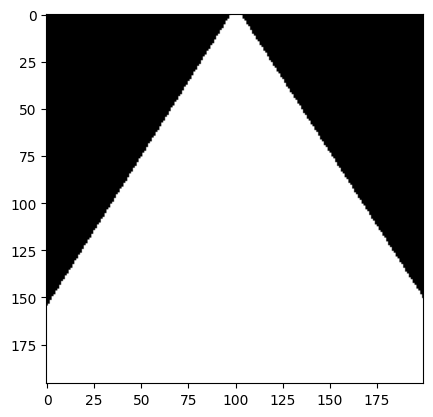

In [49]:
mask = get_visible_mask(
    cam_intrinsic,
    sample_data["width"],
    extents=[-25.0, 1.0, 25.0, 50.0],
    resolution=0.25,
)
plt.imshow(mask, cmap="gray")